In [1]:
# Set whether this notebook is run in colab or not
colab = True

# Prepare folder (to run just the first time)

In [2]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


# Initialization

In [3]:
from tensorflow.python.client import device_lib

import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Settings for reproducibility
random_seed = 44
tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.keras.utils.set_random_seed(random_seed)


def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]


print('Available devices:', get_available_devices())

#tf.debugging.set_log_device_placement(True)

Available devices: ['/device:CPU:0', '/device:GPU:0']


In [4]:
# Set mixed precision
# https://www.tensorflow.org/guide/mixed_precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [5]:
# Path to the working directory
if colab:
    #%cd -0
    #%cd "/content/drive/MyDrive/green_areas_detection"
    #%cp -R "/content/drive/MyDrive/green_areas_detection/dataset" "./"
    base_dir = '/content/drive/MyDrive/green_areas_detection'
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/models" "./"
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/utils" "./"
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/weights" "./"
else:
    base_dir = ''

In [ ]:
# TRANSFORMING SHP FILES INTO BINARY IMAGES (i.e. masks)

from utils.PyMask import shpToMask
import os 

dataset_folder = 'dataset'
samples_names = os.listdir(dataset_folder)

valid_samples_names = ['19K59', '19K35', '19K38', '18K11', '19K53']

for sample_name in samples_names:
    if sample_name in valid_samples_names:
        sample_folder_path = os.path.join(dataset_folder, sample_name) 
        #print(sample_folder_path)
        img_path = os.path.join(sample_folder_path, f'{sample_name}.tif')
        #print(img_path)
        shp_path = os.path.join(sample_folder_path, 'green_areas_shp', f'{sample_name}_greenareas.shp')
        #print(shp_path)
        shpToMask(img_path, shp_path)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (98211778 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


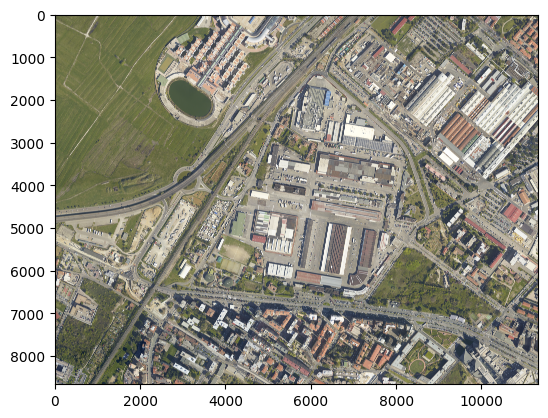

In [6]:
# Visualize one image
img = Image.open(os.path.join(base_dir, 'dataset', '19K35', '19K35.tif'))
img = np.array(img)[:, :, :3]
plt.imshow(img)

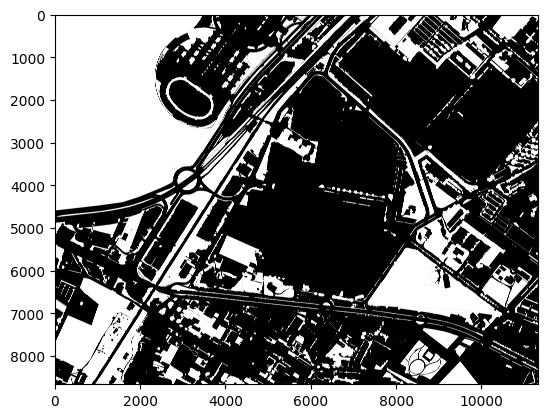

In [7]:
# Visualize one mask
mask = Image.open(os.path.join(base_dir, 'dataset', '19K35', '19K35_mask.png'))
mask = np.array(mask)
plt.imshow(mask)

# Prepare dataset

### Load dataset

We use $4$ images for the training : `19K35`, `19K38`, `19K53`, `18K11`.

We use $1$ image for the validation : `19K59`.  

We use all the four channels : RGB + infrared.

In [8]:
from utils.dataset_handler import load_images_masks

dataset_folder = os.path.join(base_dir, 'dataset')
#samples_names = os.listdir(dataset_folder)

#valid_samples_names = ['19K35', '19K38']
train_samples_names = ['19K35', '19K38', '19K53', '18K11']
val_samples_names = ['19K59']
test_samples_names = []

train_images, train_masks = load_images_masks(dataset_folder, train_samples_names, infrared=True)
print('Train shapes:', train_images.shape, train_masks.shape)

val_images, val_masks = load_images_masks(dataset_folder, val_samples_names, infrared=True)
print('Val shapes:', val_images.shape, val_masks.shape)

test_images, test_masks = load_images_masks(dataset_folder, test_samples_names, infrared=True)
print('Test shapes:', test_images.shape, test_masks.shape)

Train shapes: (4, 8666, 11333, 4) (4, 8666, 11333, 1)
Val shapes: (1, 8666, 11333, 4) (1, 8666, 11333, 1)
Test shapes: (0,) (0,)


### Crop dataset

In [9]:
from utils.dataset_handler import crop_images_masks

crop_size = 1024
step = 512

train_cropped_images, train_cropped_masks = crop_images_masks(train_images, train_masks, crop_size, step)
print('Train shapes:', train_cropped_images.shape, train_cropped_masks.shape)

val_cropped_images, val_cropped_masks = crop_images_masks(val_images, val_masks, crop_size, step)
print('Val shapes:', val_cropped_images.shape, val_cropped_masks.shape)

#test_cropped_images, test_cropped_masks = crop(test_images, test_masks, crop_size, step)
#print('Test shapes:', test_cropped_images.shape, test_cropped_masks.shape)

Train shapes: (1408, 1024, 1024, 4) (1408, 1024, 1024, 1)
Val shapes: (352, 1024, 1024, 4) (352, 1024, 1024, 1)


<Figure size 640x480 with 0 Axes>

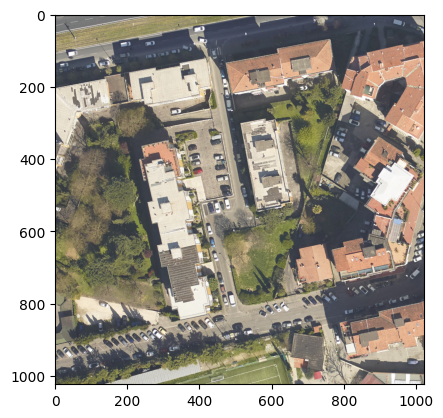

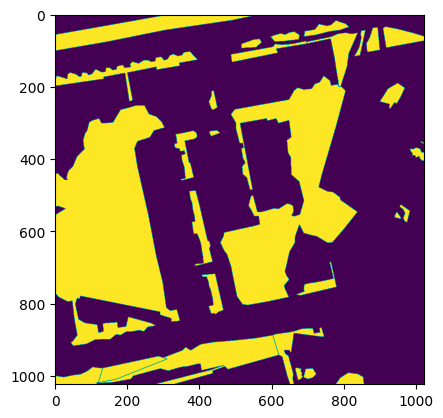

<Figure size 640x480 with 0 Axes>

In [10]:
# Visualize one crop image and mask
index = 36
plt.imshow(val_cropped_images[index, :, :, :3])
plt.figure()
#plt.imshow(infrared[index, :, :])
#plt.figure()
plt.imshow(val_cropped_masks[index, :, :])
plt.figure()

### Normalizing the input: NO

In [ ]:
# Normalizing input images
# NO: much more RAM memory recquired. Over 60GB RAM.
# We keep integer values: no worse results

#images_dataset = images_dataset.astype(np.float16)/255
#images_dataset.min(), images_dataset.max()

# Unet

In [12]:
from models.green_areas_detection_models import build_unet
unet = build_unet(input_shape=(crop_size,crop_size,4))

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 4)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         1184      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 32)         0         ['batch_normalization[0][0

### Train

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from models.callbacks import DisplayCallback

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', patience=3, min_delta=0.01)

callback_checkpoint = ModelCheckpoint('UNET.{epoch:02d}-{val_binary_accuracy:.4f}.hdf5', save_weights_only=True,
                                      save_best_only=True, monitor='val_binary_accuracy')

"""earlystopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)"""

# Visualize evolution of the predictions on the 37th validation crop during training
index = 36
display_callback = DisplayCallback(val_cropped_images[index, :, :, :], val_cropped_masks[index, :, :], 5)

callbacks = [reduce_lr_callback, callback_checkpoint, display_callback] #, earlystopping_callback]

Epoch 1/30
1/1 [==============================] - 1s 999ms/step


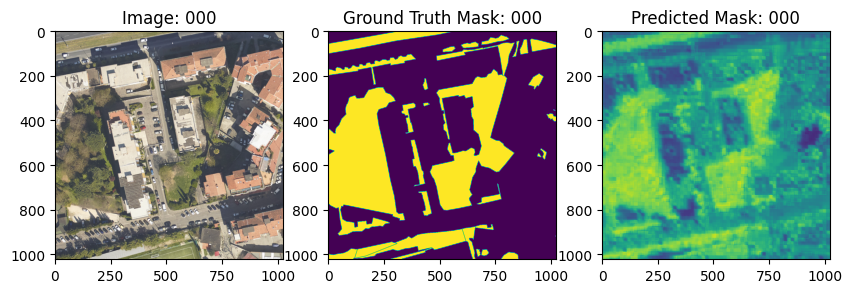

352/352 [==============================] - 81s 153ms/step - loss: 0.3263 - binary_accuracy: 0.8988 - val_loss: 0.5311 - val_binary_accuracy: 0.7282 - lr: 0.0010
Epoch 2/30
352/352 [==============================] - 48s 137ms/step - loss: 0.1662 - binary_accuracy: 0.9407 - val_loss: 0.3261 - val_binary_accuracy: 0.8634 - lr: 0.0010
Epoch 3/30
352/352 [==============================] - 48s 136ms/step - loss: 0.1315 - binary_accuracy: 0.9506 - val_loss: 0.3029 - val_binary_accuracy: 0.9064 - lr: 0.0010
Epoch 4/30
352/352 [==============================] - 48s 136ms/step - loss: 0.1227 - binary_accuracy: 0.9542 - val_loss: 0.2643 - val_binary_accuracy: 0.8908 - lr: 0.0010
Epoch 5/30
352/352 [==============================] - 48s 136ms/step - loss: 0.1311 - binary_accuracy: 0.9512 - val_loss: 0.1661 - val_binary_accuracy: 0.9349 - lr: 0.0010
Epoch 6/30
1/1 [==============================] - 0s 26ms/step


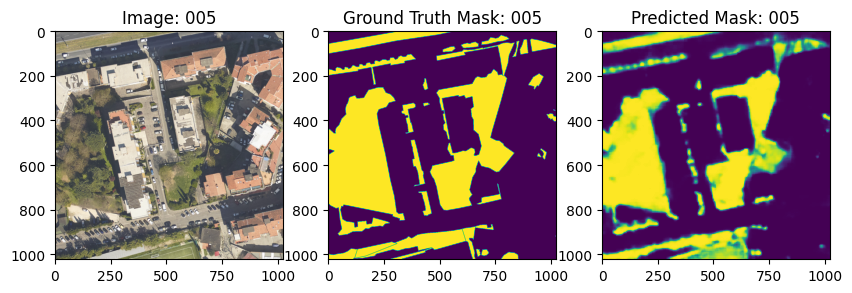

352/352 [==============================] - 49s 138ms/step - loss: 0.1104 - binary_accuracy: 0.9593 - val_loss: 0.1909 - val_binary_accuracy: 0.9350 - lr: 0.0010
Epoch 7/30
352/352 [==============================] - 48s 136ms/step - loss: 0.1047 - binary_accuracy: 0.9611 - val_loss: 0.1357 - val_binary_accuracy: 0.9464 - lr: 0.0010
Epoch 8/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0960 - binary_accuracy: 0.9640 - val_loss: 0.1277 - val_binary_accuracy: 0.9507 - lr: 0.0010
Epoch 9/30
352/352 [==============================] - 48s 136ms/step - loss: 0.1046 - binary_accuracy: 0.9603 - val_loss: 0.2140 - val_binary_accuracy: 0.9266 - lr: 0.0010
Epoch 10/30
352/352 [==============================] - 48s 137ms/step - loss: 0.0916 - binary_accuracy: 0.9654 - val_loss: 0.1194 - val_binary_accuracy: 0.9518 - lr: 0.0010
Epoch 11/30
1/1 [==============================] - 0s 22ms/step


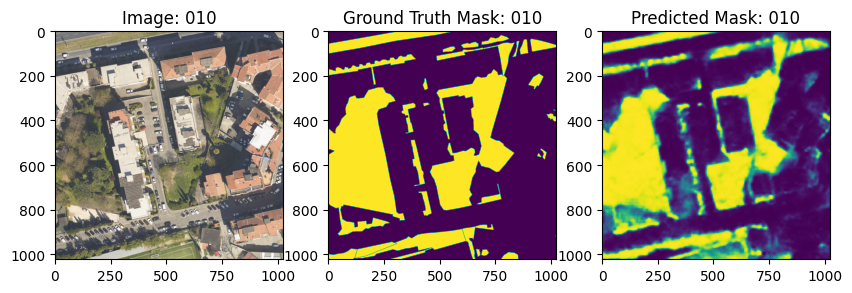

352/352 [==============================] - 49s 139ms/step - loss: 0.0915 - binary_accuracy: 0.9661 - val_loss: 0.1208 - val_binary_accuracy: 0.9529 - lr: 0.0010
Epoch 12/30
352/352 [==============================] - 48s 137ms/step - loss: 0.0780 - binary_accuracy: 0.9701 - val_loss: 0.1089 - val_binary_accuracy: 0.9575 - lr: 1.0000e-04
Epoch 13/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0756 - binary_accuracy: 0.9711 - val_loss: 0.1135 - val_binary_accuracy: 0.9564 - lr: 1.0000e-04
Epoch 14/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0744 - binary_accuracy: 0.9715 - val_loss: 0.1090 - val_binary_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 15/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0723 - binary_accuracy: 0.9721 - val_loss: 0.1097 - val_binary_accuracy: 0.9572 - lr: 1.0000e-04
Epoch 16/30
1/1 [==============================] - 0s 22ms/step


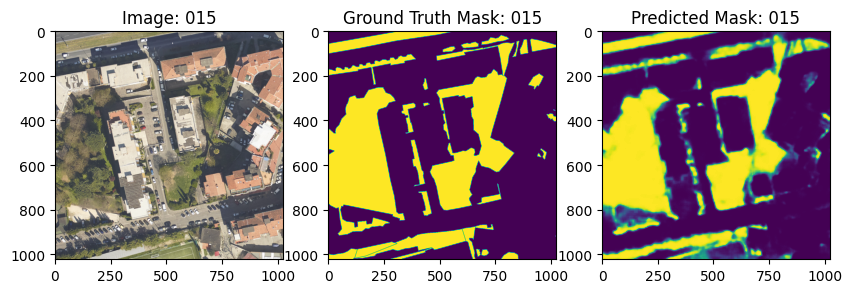

352/352 [==============================] - 49s 138ms/step - loss: 0.0710 - binary_accuracy: 0.9727 - val_loss: 0.1098 - val_binary_accuracy: 0.9576 - lr: 1.0000e-05
Epoch 17/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0707 - binary_accuracy: 0.9726 - val_loss: 0.1103 - val_binary_accuracy: 0.9574 - lr: 1.0000e-05
Epoch 18/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0698 - binary_accuracy: 0.9728 - val_loss: 0.1099 - val_binary_accuracy: 0.9575 - lr: 1.0000e-05
Epoch 19/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0702 - binary_accuracy: 0.9727 - val_loss: 0.1096 - val_binary_accuracy: 0.9575 - lr: 1.0000e-06
Epoch 20/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0699 - binary_accuracy: 0.9729 - val_loss: 0.1096 - val_binary_accuracy: 0.9576 - lr: 1.0000e-06
Epoch 21/30
1/1 [==============================] - 0s 23ms/step


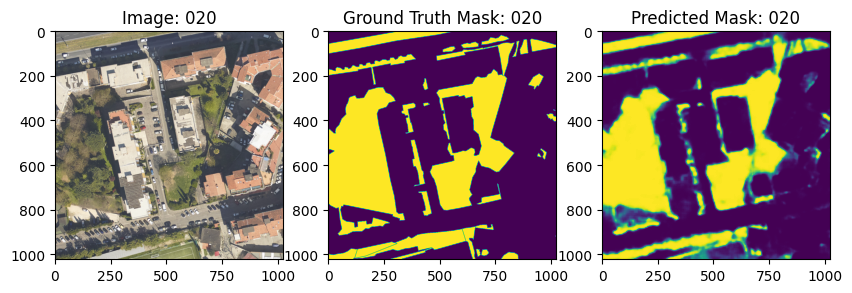

352/352 [==============================] - 49s 139ms/step - loss: 0.0699 - binary_accuracy: 0.9729 - val_loss: 0.1096 - val_binary_accuracy: 0.9575 - lr: 1.0000e-06
Epoch 22/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0700 - binary_accuracy: 0.9729 - val_loss: 0.1098 - val_binary_accuracy: 0.9575 - lr: 1.0000e-07
Epoch 23/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0697 - binary_accuracy: 0.9728 - val_loss: 0.1098 - val_binary_accuracy: 0.9575 - lr: 1.0000e-07
Epoch 24/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0708 - binary_accuracy: 0.9727 - val_loss: 0.1097 - val_binary_accuracy: 0.9575 - lr: 1.0000e-07
Epoch 25/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0698 - binary_accuracy: 0.9729 - val_loss: 0.1096 - val_binary_accuracy: 0.9576 - lr: 1.0000e-08
Epoch 26/30
1/1 [==============================] - 0s 22ms/step


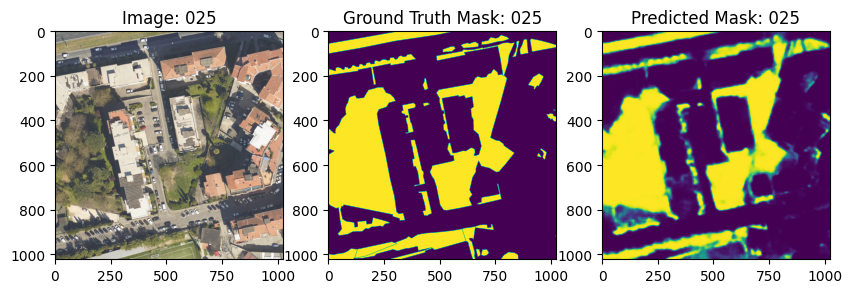

352/352 [==============================] - 49s 138ms/step - loss: 0.0696 - binary_accuracy: 0.9729 - val_loss: 0.1098 - val_binary_accuracy: 0.9574 - lr: 1.0000e-08
Epoch 27/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0698 - binary_accuracy: 0.9729 - val_loss: 0.1099 - val_binary_accuracy: 0.9575 - lr: 1.0000e-08
Epoch 28/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0695 - binary_accuracy: 0.9728 - val_loss: 0.1097 - val_binary_accuracy: 0.9575 - lr: 1.0000e-09
Epoch 29/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0696 - binary_accuracy: 0.9729 - val_loss: 0.1096 - val_binary_accuracy: 0.9575 - lr: 1.0000e-09
Epoch 30/30
352/352 [==============================] - 48s 136ms/step - loss: 0.0696 - binary_accuracy: 0.9729 - val_loss: 0.1098 - val_binary_accuracy: 0.9575 - lr: 1.0000e-09


In [ ]:
# System RAM : ~25GB
# GPU RAM : ~15GB
hist = unet.fit(train_cropped_images, train_cropped_masks, batch_size=4,
                epochs=30, callbacks=callbacks,
                validation_data=(val_cropped_images,val_cropped_masks))

Best validation score: $0.9576$, epoch $16$.
Associated training score: $0.9727$.

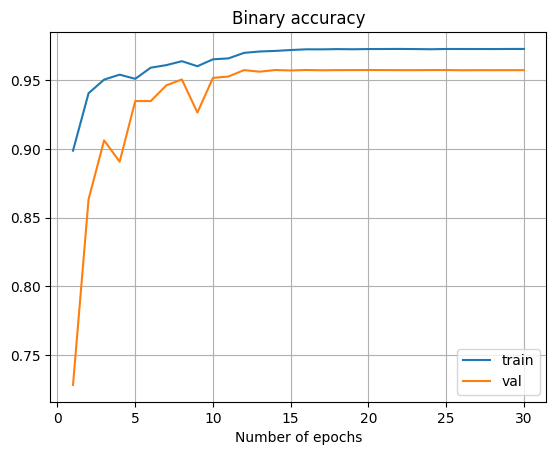

In [ ]:
from utils.evaluation import plot_history
plot_history(hist)

### Load best model

In [13]:
unet.load_weights(os.path.join('weights', 'UNET.16-0.9576 INFRARED.hdf5'))

### Visualize the predictions on a validation crop

(1024, 1024, 4)
1/1 [==============================] - 11s 11s/step


<Figure size 640x480 with 0 Axes>

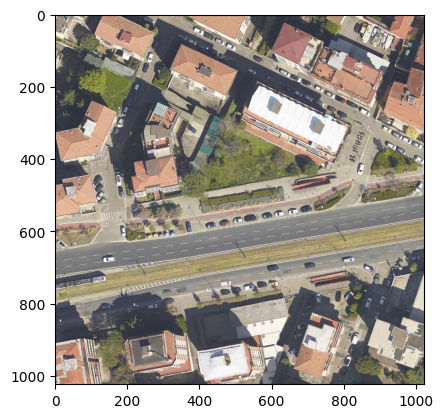

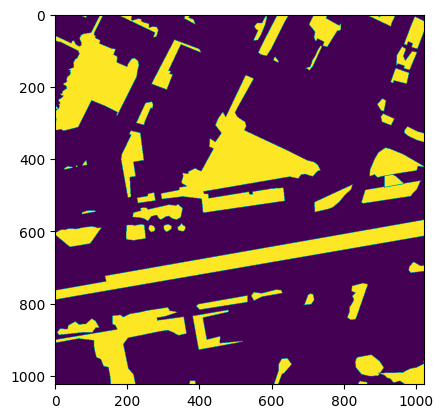

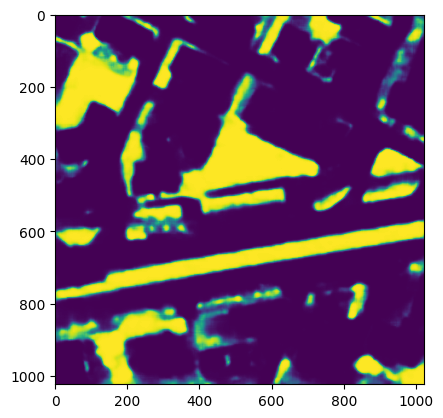

<Figure size 640x480 with 0 Axes>

In [14]:
# Visualize the predicted scores on a validation crop

index = 12
img = val_cropped_images[index, :, :, :]
mask = val_cropped_masks[index, :, :, 0]

plt.imshow(img[:, :, :3])
plt.figure()

plt.imshow(mask, vmin=0, vmax=1)
plt.figure()

print(img.shape)
img = np.expand_dims(img, axis=0)
pred = unet.predict(img)
binary_preds = np.argmax(pred, axis=-1).astype('uint8')
binary_preds = binary_preds[0, :]
#binary_mask = Image.fromarray(binary_preds)
#plt.imshow(binary_preds[..., 0])#cmap='gray', vmin=0, vmax=1)
plt.imshow(pred[0, :, :, 0], vmin=0, vmax=1)
plt.figure()

### Validation crops evaluation
Evaluation on the validation crops.

In [ ]:
from utils.evaluation import compute_pixelwise_retrieval_metrics

val_cropped_preds = unet.predict(val_cropped_images, batch_size=4)
compute_pixelwise_retrieval_metrics(val_cropped_preds[..., 0], val_cropped_masks[..., 0])

88/88 [==============================] - 13s 30ms/step


{'auroc': 0.9922036284198035,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99999997, 0.99999999,
        1.        ]),
 'tpr': array([0.0000000e+00, 1.3723128e-08, 1.3723128e-07, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00]),
 'optimal_threshold': 0.46268547,
 'optimal_fpr': 0.02060541781512174,
 'optimal_fnr': 0.021893682804974644}

Auroc: $0.9922$. Optimal threshold: $0.46$.

### Validation full image evaluation
Evaluation on the full validation image. First on the binary predictions, and then on the polylines mask.


**1) Binary predictions**

In [ ]:
# GPU RAM : ~3GB
# Time : ~1 min (T4 GPU)

from utils.utils import predict_on_img

val_img = val_images[0]
val_mask = val_masks[0]

# Predictions on the full validation image.
# (Basically, aggregation of the predictions on the crops).
val_preds = predict_on_img(unet, val_img, step=step, batch_size=4,
                           crop_size=crop_size, use_gaussian=False);

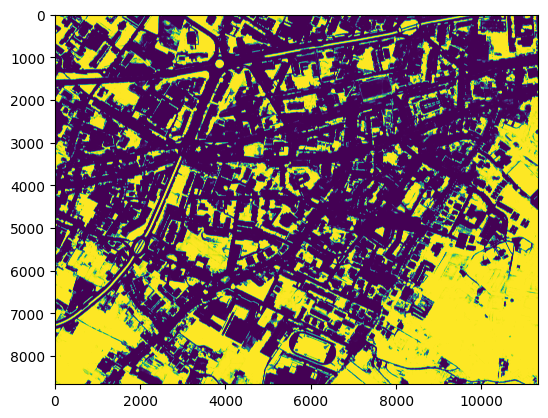

In [16]:
plt.imshow(val_preds)

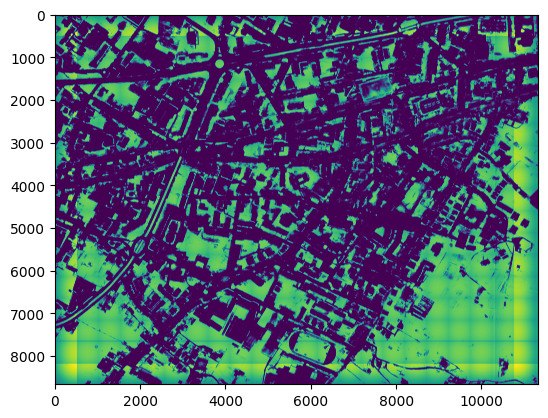

In [ ]:
# TO DELETE
# With gaussian smoothing
plt.imshow(val_preds)

In [25]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9578512>

Binary accuracy: $0.9578$.

In [26]:
# With best threshold
threshold = 0.46
acc = tf.keras.metrics.BinaryAccuracy(threshold=threshold)
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9577698>

In [27]:
from utils.evaluation import compute_pixelwise_retrieval_metrics
compute_pixelwise_retrieval_metrics(val_preds[..., 0], val_mask[..., 0])

{'auroc': 0.9923834080663967,
 'fpr': array([0.00000000e+00, 5.23124800e-05, 1.64659839e-04, ...,
        9.94942608e-01, 9.98416231e-01, 1.00000000e+00]),
 'tpr': array([0.        , 0.10701291, 0.31105197, ..., 1.        , 1.        ,
        1.        ]),
 'optimal_threshold': 0.4595,
 'optimal_fpr': 0.020482899719013334,
 'optimal_fnr': 0.02175027316988396}

Auroc: $0.9924$. Best threshold: $0.46$.

**2) Polylines mask**

In [28]:
from PIL import ImageDraw
from utils.utils import get_polylines

# Thresholded binary predictions: either 0 or 1
binary_preds = (val_preds>threshold).astype('uint8')

# Compute the poly-lines
tolerance = 1.
min_area = 10
poly_lines = get_polylines(binary_preds, tolerance=tolerance, min_area=min_area)

# Compute the polylines mask
polyline_mask = np.zeros(shape=binary_preds.shape[:2], dtype=np.uint8)
polyline_mask = Image.fromarray(polyline_mask)
draw_polyline = ImageDraw.Draw(polyline_mask)
for p in poly_lines:
    draw_polyline.polygon(p, fill=1)
#polyline_mask.putpalette(get_palette())
#polyline_mask.save(join(out_folder, f"{img_basename}_polylines.png"))
polyline_mask = np.array(polyline_mask)

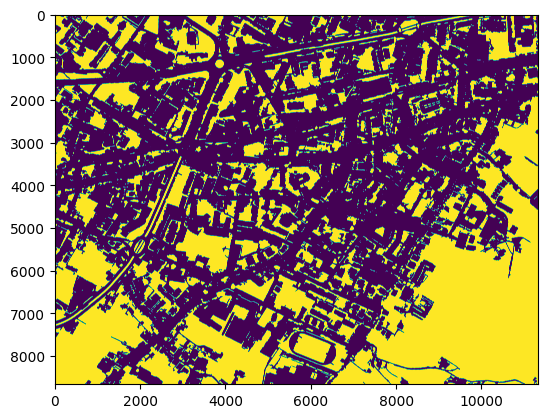

In [29]:
plt.imshow(polyline_mask)

In [30]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, polyline_mask)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9515769>

Binary accuracy: $0.9516$. Slightly worse than before ...

*The vectorization process makes the mask better looking and more regular. The price to pay is some points of the accuracy...*

In [31]:
compute_pixelwise_retrieval_metrics(polyline_mask, val_mask[..., 0])

{'auroc': 0.9512425183812544,
 'fpr': array([0.        , 0.04710584, 1.        ]),
 'tpr': array([0.        , 0.94959088, 1.        ]),
 'optimal_threshold': 1,
 'optimal_fpr': 0.02832199005703776,
 'optimal_fnr': 0.020101061605869715}

### Save the polylines mask

In [ ]:
# Save polylines mask
from utils.utils import get_palette
m = Image.fromarray(polyline_mask)
m.putpalette(get_palette())
m.save("polylines.png")

# Attention Unet

In [18]:
from models.green_areas_detection_models import build_attunet
att_unet = build_attunet(input_shape=(crop_size,crop_size,4), n_ch=32, L=3)

In [ ]:
att_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1024, 1024, 4)]      0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 1024, 1024, 32)       1184      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 1024, 1024, 32)       128       ['conv2d_9[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 1024, 1024, 32)       0         ['batch_normalization_15

### Train

In [ ]:
att_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from models.callbacks import DisplayCallback

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', patience=3, min_delta=0.01)

callback_checkpoint = ModelCheckpoint('ATT_UNET.{epoch:02d}-{val_binary_accuracy:.4f}.hdf5', save_weights_only=True,
                                      save_best_only=True, monitor='val_binary_accuracy')

"""earlystopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)"""

# Visualize evolution of the predictions on the 37th validation crop during training
index = 36
display_callback = DisplayCallback(val_cropped_images[index, :, :, :], val_cropped_masks[index, :, :], 5)

callbacks = [reduce_lr_callback, callback_checkpoint, display_callback] #, earlystopping_callback]

Epoch 1/30
1/1 [==============================] - 3s 3s/step


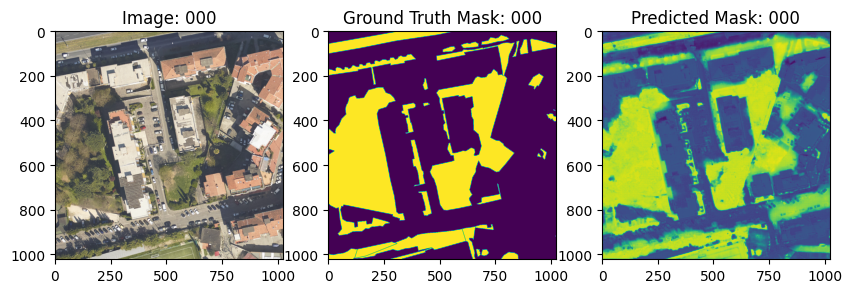

352/352 [==============================] - 204s 350ms/step - loss: 0.3852 - binary_accuracy: 0.9091 - val_loss: 0.4011 - val_binary_accuracy: 0.9121 - lr: 0.0010
Epoch 2/30
352/352 [==============================] - 116s 331ms/step - loss: 0.3175 - binary_accuracy: 0.9415 - val_loss: 0.2491 - val_binary_accuracy: 0.9331 - lr: 0.0010
Epoch 3/30
352/352 [==============================] - 116s 330ms/step - loss: 0.2714 - binary_accuracy: 0.9512 - val_loss: 0.3440 - val_binary_accuracy: 0.8643 - lr: 0.0010
Epoch 4/30
352/352 [==============================] - 116s 331ms/step - loss: 0.2385 - binary_accuracy: 0.9545 - val_loss: 0.2316 - val_binary_accuracy: 0.9466 - lr: 0.0010
Epoch 5/30
352/352 [==============================] - 116s 330ms/step - loss: 0.2193 - binary_accuracy: 0.9552 - val_loss: 0.2113 - val_binary_accuracy: 0.9442 - lr: 0.0010
Epoch 6/30
1/1 [==============================] - 0s 25ms/step


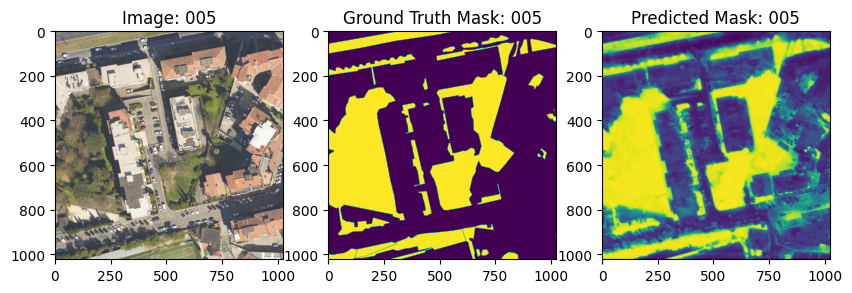

352/352 [==============================] - 117s 332ms/step - loss: 0.1997 - binary_accuracy: 0.9601 - val_loss: 0.2915 - val_binary_accuracy: 0.9057 - lr: 0.0010
Epoch 7/30
352/352 [==============================] - 116s 331ms/step - loss: 0.1924 - binary_accuracy: 0.9577 - val_loss: 0.1834 - val_binary_accuracy: 0.9496 - lr: 0.0010
Epoch 8/30
352/352 [==============================] - 116s 330ms/step - loss: 0.1663 - binary_accuracy: 0.9640 - val_loss: 0.2007 - val_binary_accuracy: 0.9303 - lr: 0.0010
Epoch 9/30
352/352 [==============================] - 116s 330ms/step - loss: 0.1797 - binary_accuracy: 0.9572 - val_loss: 0.2109 - val_binary_accuracy: 0.9401 - lr: 0.0010
Epoch 10/30
352/352 [==============================] - 116s 331ms/step - loss: 0.1528 - binary_accuracy: 0.9628 - val_loss: 0.1550 - val_binary_accuracy: 0.9517 - lr: 0.0010
Epoch 11/30
1/1 [==============================] - 0s 26ms/step


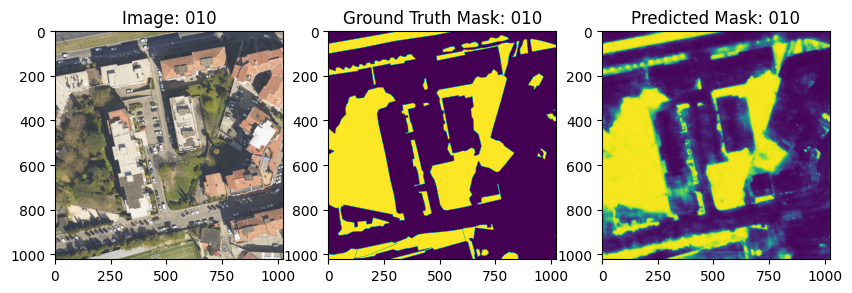

352/352 [==============================] - 117s 333ms/step - loss: 0.1520 - binary_accuracy: 0.9655 - val_loss: 0.1464 - val_binary_accuracy: 0.9566 - lr: 0.0010
Epoch 12/30
352/352 [==============================] - 116s 331ms/step - loss: 0.1413 - binary_accuracy: 0.9646 - val_loss: 0.1328 - val_binary_accuracy: 0.9579 - lr: 0.0010
Epoch 13/30
352/352 [==============================] - 116s 330ms/step - loss: 0.1303 - binary_accuracy: 0.9666 - val_loss: 0.1385 - val_binary_accuracy: 0.9498 - lr: 0.0010
Epoch 14/30
352/352 [==============================] - 116s 330ms/step - loss: 0.1366 - binary_accuracy: 0.9649 - val_loss: 0.1372 - val_binary_accuracy: 0.9520 - lr: 0.0010
Epoch 15/30
352/352 [==============================] - 116s 330ms/step - loss: 0.1258 - binary_accuracy: 0.9658 - val_loss: 0.3115 - val_binary_accuracy: 0.8682 - lr: 0.0010
Epoch 16/30
1/1 [==============================] - 0s 24ms/step


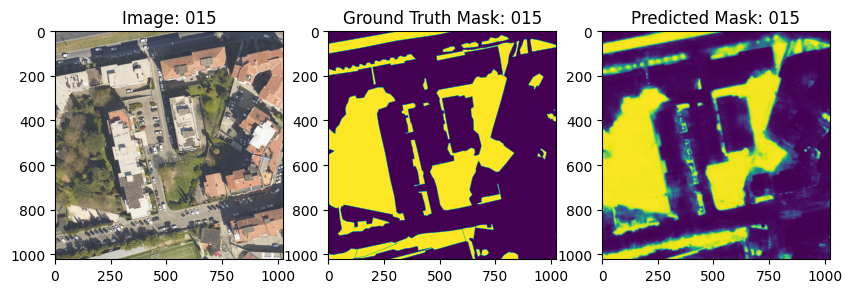

352/352 [==============================] - 117s 332ms/step - loss: 0.1202 - binary_accuracy: 0.9669 - val_loss: 0.1199 - val_binary_accuracy: 0.9566 - lr: 0.0010
Epoch 17/30
352/352 [==============================] - 116s 330ms/step - loss: 0.1246 - binary_accuracy: 0.9669 - val_loss: 0.1243 - val_binary_accuracy: 0.9528 - lr: 0.0010
Epoch 18/30
352/352 [==============================] - 116s 331ms/step - loss: 0.1065 - binary_accuracy: 0.9687 - val_loss: 0.1156 - val_binary_accuracy: 0.9580 - lr: 0.0010
Epoch 19/30
352/352 [==============================] - 116s 330ms/step - loss: 0.1164 - binary_accuracy: 0.9680 - val_loss: 0.1183 - val_binary_accuracy: 0.9566 - lr: 0.0010
Epoch 20/30
352/352 [==============================] - 116s 330ms/step - loss: 0.1091 - binary_accuracy: 0.9686 - val_loss: 0.1167 - val_binary_accuracy: 0.9557 - lr: 0.0010
Epoch 21/30
1/1 [==============================] - 0s 25ms/step


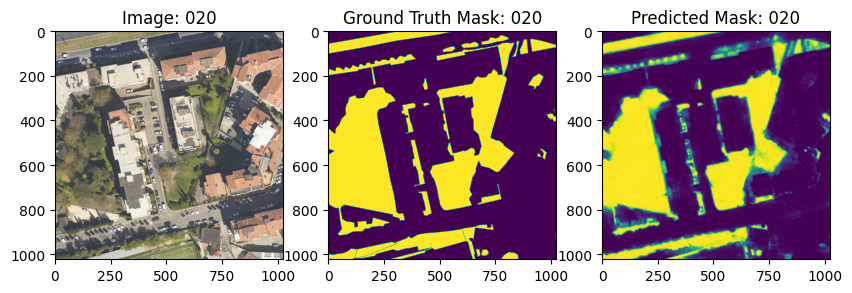

352/352 [==============================] - 117s 333ms/step - loss: 0.1023 - binary_accuracy: 0.9691 - val_loss: 0.1115 - val_binary_accuracy: 0.9572 - lr: 0.0010
Epoch 22/30
352/352 [==============================] - 116s 330ms/step - loss: 0.0948 - binary_accuracy: 0.9710 - val_loss: 0.1104 - val_binary_accuracy: 0.9574 - lr: 1.0000e-04
Epoch 23/30
352/352 [==============================] - 116s 330ms/step - loss: 0.0947 - binary_accuracy: 0.9715 - val_loss: 0.1071 - val_binary_accuracy: 0.9594 - lr: 1.0000e-04
Epoch 24/30
352/352 [==============================] - 116s 331ms/step - loss: 0.0953 - binary_accuracy: 0.9716 - val_loss: 0.1063 - val_binary_accuracy: 0.9596 - lr: 1.0000e-04
Epoch 25/30
352/352 [==============================] - 116s 331ms/step - loss: 0.0961 - binary_accuracy: 0.9718 - val_loss: 0.1092 - val_binary_accuracy: 0.9585 - lr: 1.0000e-04
Epoch 26/30
1/1 [==============================] - 0s 27ms/step


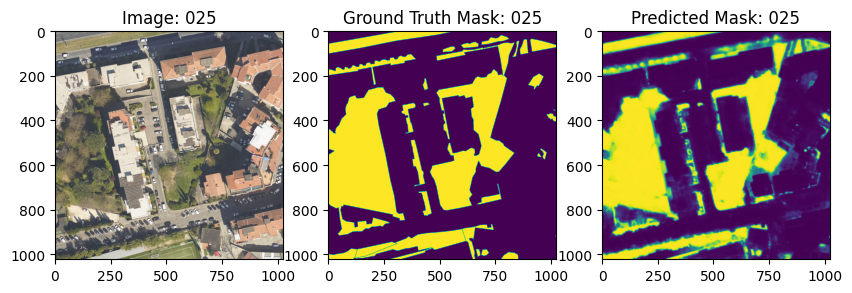

352/352 [==============================] - 117s 333ms/step - loss: 0.0917 - binary_accuracy: 0.9722 - val_loss: 0.1058 - val_binary_accuracy: 0.9597 - lr: 1.0000e-05
Epoch 27/30
352/352 [==============================] - 116s 330ms/step - loss: 0.0950 - binary_accuracy: 0.9721 - val_loss: 0.1066 - val_binary_accuracy: 0.9593 - lr: 1.0000e-05
Epoch 28/30
352/352 [==============================] - 116s 330ms/step - loss: 0.0968 - binary_accuracy: 0.9718 - val_loss: 0.1065 - val_binary_accuracy: 0.9596 - lr: 1.0000e-05
Epoch 29/30
352/352 [==============================] - 116s 331ms/step - loss: 0.0962 - binary_accuracy: 0.9721 - val_loss: 0.1058 - val_binary_accuracy: 0.9597 - lr: 1.0000e-06
Epoch 30/30
352/352 [==============================] - 116s 331ms/step - loss: 0.0949 - binary_accuracy: 0.9719 - val_loss: 0.1060 - val_binary_accuracy: 0.9596 - lr: 1.0000e-06


In [ ]:
# System RAM : ~25GB
# GPU RAM : ~35GB

hist = att_unet.fit(train_cropped_images, train_cropped_masks, batch_size=4,
                epochs=30, callbacks=callbacks,
                validation_data=(val_cropped_images,val_cropped_masks))

Best validation score: $0.9597$, epoch $29$.
Associated training score: $0.9721$.

Better than UNET!

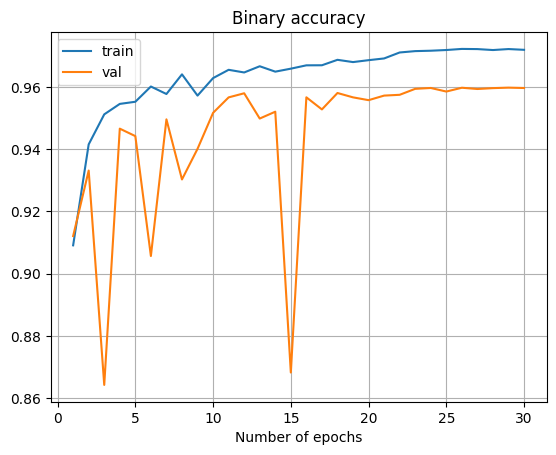

In [ ]:
from utils.evaluation import plot_history
plot_history(hist)

### Load best model

In [19]:
att_unet.load_weights(os.path.join('weights', 'ATT_UNET.29-0.9597 INFRARED.hdf5'))

### Visualize the predictions on a validation crop

(1024, 1024, 4)
1/1 [==============================] - 4s 4s/step


<Figure size 640x480 with 0 Axes>

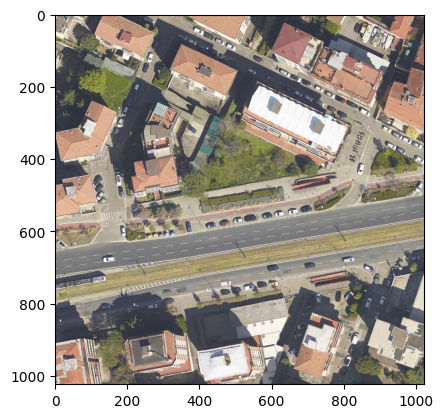

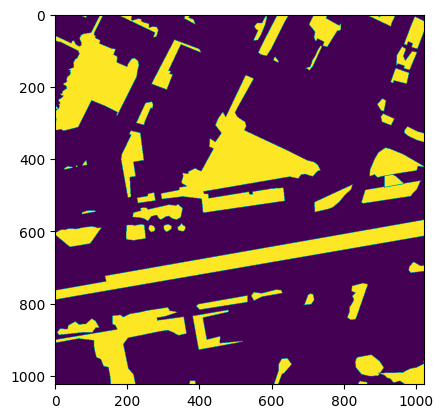

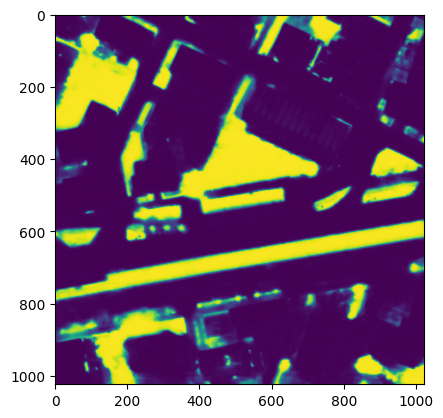

<Figure size 640x480 with 0 Axes>

In [20]:
# Visualize the predicted scores on a validation crop

index = 12
img = val_cropped_images[index, :, :, :]
mask = val_cropped_masks[index, :, :, 0]

plt.imshow(img[:, :, :3])
plt.figure()

plt.imshow(mask, vmin=0, vmax=1)
plt.figure()

print(img.shape)
img = np.expand_dims(img, axis=0)
pred = att_unet.predict(img)
binary_preds = np.argmax(pred, axis=-1).astype('uint8')
binary_preds = binary_preds[0, :]
#binary_mask = Image.fromarray(binary_preds)
#plt.imshow(binary_preds[..., 0])#cmap='gray', vmin=0, vmax=1)
plt.imshow(pred[0, :, :, 0], vmin=0, vmax=1)
plt.figure()

### Validation crops evaluation
Evaluation on the validation crops.

In [32]:
from utils.evaluation import compute_pixelwise_retrieval_metrics

val_cropped_preds = att_unet.predict(val_cropped_images, batch_size=4)
compute_pixelwise_retrieval_metrics(val_cropped_preds[..., 0], val_cropped_masks[..., 0])

88/88 [==============================] - 22s 255ms/step


{'auroc': 0.9929685909014492,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99999996, 0.99999998,
        1.        ]),
 'tpr': array([0.00000000e+00, 1.37231280e-08, 1.23508152e-07, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'optimal_threshold': 0.416144,
 'optimal_fpr': 0.019736574454741043,
 'optimal_fnr': 0.020152162421833385}

Auroc: $0.9929$. Optimal threshold: $0.42$.

Better than UNET!

### Validation full image evaluation
Evaluation on the full validation image. First on the binary predictions, and then on the polylines mask.


**1) Binary predictions**

In [ ]:
# GPU RAM : ~9GB
# Time : couple of minutes (T4 GPU)

from utils.utils import predict_on_img

val_img = val_images[0]
val_mask = val_masks[0]

# Predictions on the full validation image.
# (Basically, aggregation of the predictions on the crops).
val_preds = predict_on_img(att_unet, val_img, step=step, batch_size=4,
                           crop_size=crop_size, use_gaussian=False);

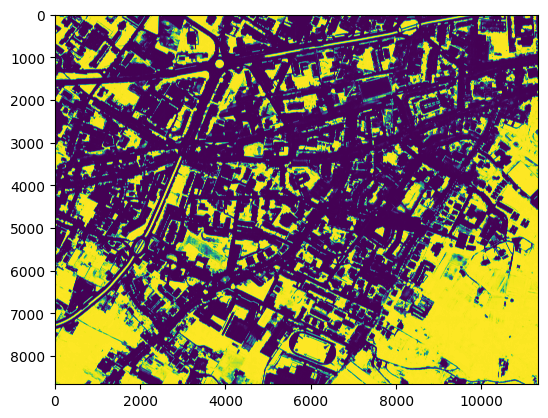

In [34]:
plt.imshow(val_preds)

In [35]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9596669>

Binary accuracy: $0.9597$.

In [36]:
# With best threshold
threshold = 0.45
acc = tf.keras.metrics.BinaryAccuracy(threshold=0.42)
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.96013343>

Binary accuracy: $0.96$.

In [37]:
from utils.evaluation import compute_pixelwise_retrieval_metrics
compute_pixelwise_retrieval_metrics(val_preds[..., 0], val_mask[..., 0])

{'auroc': 0.9930861640563893,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99999988, 0.99999998,
        1.        ]),
 'tpr': array([0.00000000e+00, 8.70724904e-06, 1.60611720e-05, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'optimal_threshold': 0.4175,
 'optimal_fpr': 0.019546443808399438,
 'optimal_fnr': 0.020331003476996415}

Auroc: $0.993$. Best threshold: $0.417$.

Better than UNET!

**2) Polylines mask**

In [38]:
from PIL import ImageDraw
from utils.utils import get_polylines

# Thresholded binary predictions: either 0 or 1
binary_preds = (val_preds>threshold).astype('uint8')

# Compute the poly-lines
tolerance = 1.
min_area = 10
poly_lines = get_polylines(binary_preds, tolerance=tolerance, min_area=min_area)

# Compute the polylines mask
polyline_mask = np.zeros(shape=binary_preds.shape[:2], dtype=np.uint8)
polyline_mask = Image.fromarray(polyline_mask)
draw_polyline = ImageDraw.Draw(polyline_mask)
for p in poly_lines:
    draw_polyline.polygon(p, fill=1)
#polyline_mask.putpalette(get_palette())
#polyline_mask.save(join(out_folder, f"{img_basename}_polylines.png"))
polyline_mask = np.array(polyline_mask)

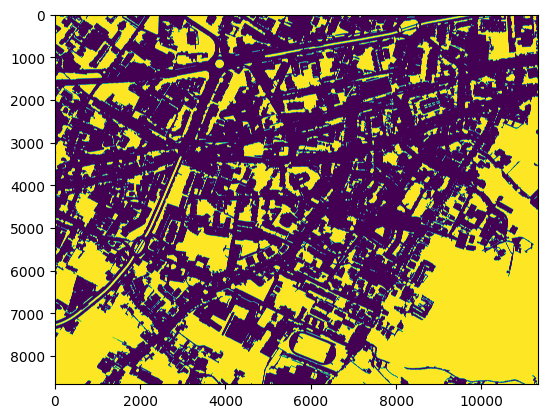

In [39]:
plt.imshow(polyline_mask)

In [40]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, polyline_mask)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.95426714>

Binary accuracy: $0.954$. Better than UNET!

*We remind that the vectorization process makes the mask better looking and more regular. The price to pay is some points of the accuracy...*

In [41]:
compute_pixelwise_retrieval_metrics(polyline_mask, val_mask[..., 0])

{'auroc': 0.9535897569472043,
 'fpr': array([0.        , 0.04306484, 1.        ]),
 'tpr': array([0.        , 0.95024435, 1.        ]),
 'optimal_threshold': 1,
 'optimal_fpr': 0.025892373112316527,
 'optimal_fnr': 0.019840481861554324}

Auroc: $0.9536$.

### Save the polylines mask

In [ ]:
# Save polylines mask
from utils.utils import get_palette
m = Image.fromarray(polyline_mask)
m.putpalette(get_palette())
m.save("polylines.png")